In [ ]:
import glob
import os
import shutil
from pathlib import Path

In [ ]:
#upload the data on your google drive and connect that drive with this cell
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#unziping the data and putting the folders in a new folder named "data"
!unzip "/content/drive/MyDrive/chest_xray.zip"

In [ ]:
#counting the train data of each class
for i in os.listdir("/content/chest_xray/train"):
  try:
    c = len(os.listdir(os.path.join("/content/chest_xray/train",i)))
    print(i+": "+str(c))
  except:
    pass

PNEUMONIA: 3875
NORMAL: 1341


In [ ]:
path = "/content/chest_xray/test/"
sub_folder = "PNEUMONIA"
new_folder = os.path.join(path,"virus")
print(new_folder)
if not os.path.exists(new_folder):
  os.mkdir(new_folder)

for i in os.listdir(path+sub_folder):
  if i.split("_")[1] == "virus":
    shutil.move(os.path.join(path+sub_folder,i), os.path.join(new_folder,i))

os.rename(path+sub_folder, path+"bacteria")


/content/chest_xray/test/virus


In [ ]:
path = "/content/chest_xray/train/"
sub_folder = "PNEUMONIA"
new_folder = os.path.join(path,"virus")
print(new_folder)
if not os.path.exists(new_folder):
  os.mkdir(new_folder)

for i in os.listdir(path+sub_folder):
  if i.split("_")[1] == "virus":
    shutil.move(os.path.join(path+sub_folder,i), os.path.join(new_folder,i))


os.rename(path+sub_folder, path+"bacteria")

/content/chest_xray/train/virus


In [ ]:
new_data_folder = "data"
if not os.path.exists(new_data_folder):
  os.mkdir(new_data_folder)

train_folder = "/content/chest_xray/train"
test_folder = "/content/chest_xray/test"

for sub in os.listdir(train_folder):
  trg_path = os.path.join(new_data_folder,sub)

  if not os.path.exists(trg_path):
    os.mkdir(trg_path)

  for src_file in Path(os.path.join(train_folder,sub)).glob('*.*'):
    shutil.copy(src_file, trg_path)

  for src_file in Path(os.path.join(test_folder,sub)).glob('*.*'):
    shutil.copy(src_file, trg_path)
   








In [ ]:
#counting the train data of each class

data_num = {}
for i in os.listdir("/content/data"):
  try:
    c = len(os.listdir(os.path.join("/content/data",i)))
    print(i+": "+str(c))
    data_num[i] = c
  except:
    pass

virus: 1493
bacteria: 2772
NORMAL: 1575


In [ ]:
data_num

{'NORMAL': 1575, 'bacteria': 2772, 'virus': 1493}

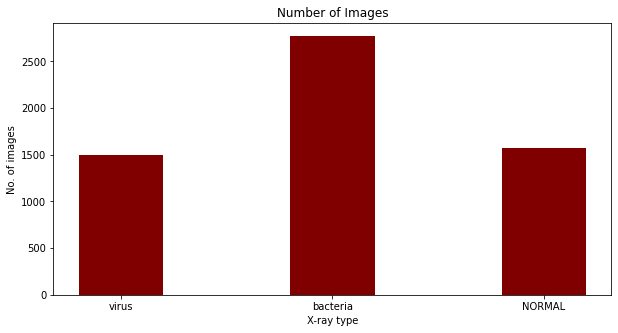

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
 
  
# creating the dataset
data = data_num
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("X-ray type")
plt.ylabel("No. of images")
plt.title("Number of Images")
plt.show()

In [ ]:


import cv2
from skimage.exposure import rescale_intensity
from skimage.segmentation import slic
from skimage.util import img_as_float
from skimage import io
import numpy as np



#RESIZE
def resize_image(image,w,h):
    image=cv2.resize(image,(w,h))
    cv2.imwrite(Folder_name+"/Resize-"+str(w)+"*"+str(h)+Extension, image)

#crop
def crop_image(image,y1,y2,x1,x2):
    image=image[y1:y2,x1:x2]
    cv2.imwrite(Folder_name+"/Crop-"+str(x1)+str(x2)+"*"+str(y1)+str(y2)+Extension, image)

def padding_image(image,topBorder,bottomBorder,leftBorder,rightBorder,color_of_border=[0,0,0]):
    image = cv2.copyMakeBorder(image,topBorder,bottomBorder,leftBorder,
        rightBorder,cv2.BORDER_CONSTANT,value=color_of_border)
    cv2.imwrite(Folder_name + "/padd-" + str(topBorder) + str(bottomBorder) + "*" + str(leftBorder) + str(rightBorder) + Extension, image)

def flip_image(image,dir):
    image = cv2.flip(image, dir)
    cv2.imwrite(Folder_name + "/flip-" + str(dir)+Extension, image)

def superpixel_image(image,segments):
    seg=segments

    def segment_colorfulness(image, mask):
        # split the image into its respective RGB components, then mask
        # each of the individual RGB channels so we can compute
        # statistics only for the masked region
        (B, G, R) = cv2.split(image.astype("float"))
        R = np.ma.masked_array(R, mask=mask)
        G = np.ma.masked_array(B, mask=mask)
        B = np.ma.masked_array(B, mask=mask)

        # compute rg = R - G
        rg = np.absolute(R - G)

        # compute yb = 0.5 * (R + G) - B
        yb = np.absolute(0.5 * (R + G) - B)

        # compute the mean and standard deviation of both `rg` and `yb`,
        # then combine them
        stdRoot = np.sqrt((rg.std() ** 2) + (yb.std() ** 2))
        meanRoot = np.sqrt((rg.mean() ** 2) + (yb.mean() ** 2))

        # derive the "colorfulness" metric and return it
        return stdRoot + (0.3 * meanRoot)

    orig = cv2.imread(image)
    vis = np.zeros(orig.shape[:2], dtype="float")

    # load the image and apply SLIC superpixel segmentation to it via
    # scikit-image
    image = io.imread(image)
    segments = slic(img_as_float(image), n_segments=segments,
                    slic_zero=True)
    for v in np.unique(segments):
        # construct a mask for the segment so we can compute image
        # statistics for *only* the masked region
        mask = np.ones(image.shape[:2])
        mask[segments == v] = 0

        # compute the superpixel colorfulness, then update the
        # visualization array
        C = segment_colorfulness(orig, mask)
        vis[segments == v] = C
    # scale the visualization image from an unrestricted floating point
    # to unsigned 8-bit integer array so we can use it with OpenCV and
    # display it to our screen
    vis = rescale_intensity(vis, out_range=(0, 255)).astype("uint8")

    # overlay the superpixel colorfulness visualization on the original
    # image
    alpha = 0.6
    overlay = np.dstack([vis] * 3)
    output = orig.copy()
    cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)
    # cv2.imshow("Visualization", vis)
    cv2.imwrite(Folder_name + "/superpixels-" + str(seg) + Extension, output)

def invert_image(image,channel):
    # image=cv2.bitwise_not(image)
    image=(channel-image)
    cv2.imwrite(Folder_name + "/invert-"+str(channel)+Extension, image)

def add_light(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    image=cv2.LUT(image, table)
    if gamma>=1:
        cv2.imwrite(Folder_name + "/light-"+str(gamma)+Extension, image)
    else:
        cv2.imwrite(Folder_name + "/dark-" + str(gamma) + Extension, image)

def add_light_color(image, color, gamma=1.0):
    invGamma = 1.0 / gamma
    image = (color - image)
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    image=cv2.LUT(image, table)
    if gamma>=1:
        cv2.imwrite(Folder_name + "/light_color-"+str(gamma)+Extension, image)
    else:
        cv2.imwrite(Folder_name + "/dark_color" + str(gamma) + Extension, image)

def saturation_image(image,saturation):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    v = image[:, :, 2]
    v = np.where(v <= 255 - saturation, v + saturation, 255)
    image[:, :, 2] = v

    image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
    cv2.imwrite(Folder_name + "/saturation-" + str(saturation) + Extension, image)

def hue_image(image,saturation):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    v = image[:, :, 2]
    v = np.where(v <= 255 + saturation, v - saturation, 255)
    image[:, :, 2] = v

    image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
    cv2.imwrite(Folder_name +"/hue-" + str(saturation) + Extension, image)




In [ ]:
!pip install imagecodecs

     |████████████████████████████████| 31.0 MB 1.4 MB/s 


In [ ]:
import os
folder_path = "/content/data/NORMAL"
for img in os.listdir(folder_path):
    simg_path = os.path.join(folder_path,img)
    print(simg_path)
    
    
    image_file=simg_path
    Folder_name=folder_path
    Extension=image_file.split("/")[-1]
    image=cv2.imread(image_file)
    

    flip_image(image,-1)#both


In [ ]:
import os
folder_path = "/content/data/virus"
for img in os.listdir(folder_path):
    simg_path = os.path.join(folder_path,img)
    print(simg_path)
    
    
    image_file=simg_path
    Folder_name=folder_path
    Extension=image_file.split("/")[-1]
    image=cv2.imread(image_file)
    

    flip_image(image,-1)#both


In [ ]:
#counting the train data of each class

data_num = {}
for i in os.listdir("/content/data"):
  try:
    c = len(os.listdir(os.path.join("/content/data",i)))
    print(i+": "+str(c))
    data_num[i] = c
  except:
    pass

virus: 2986
bacteria: 2772
NORMAL: 3150


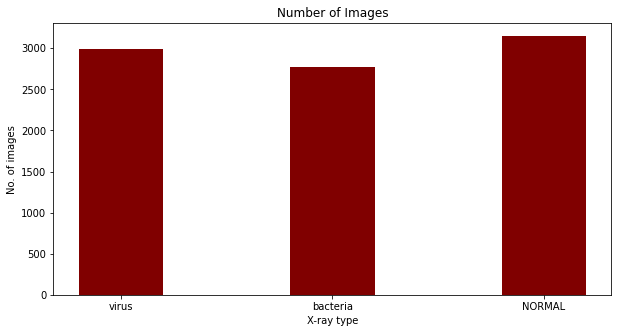

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
 
  
# creating the dataset
data = data_num
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("X-ray type")
plt.ylabel("No. of images")
plt.title("Number of Images")
plt.show()

In [ ]:
#Import different kinds of library
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [ ]:
#Load the dataset
BATCH_SIZE = 8
IMAGE_SIZE = 100
CHANNELS=3
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/data',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 8908 files belonging to 3 classes.


In [ ]:
#Class name in the dataset
class_name=dataset.class_names
class_name


['NORMAL', 'bacteria', 'virus']

In [ ]:
#image shape 
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(8, 100, 100, 3)
[0 2 2 0 0 2 0 0]


In [ ]:
#printing some data to see all ok or not
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())


[[[  7.46         7.46         7.46      ]
  [ 21.          21.          21.        ]
  [ 43.380005    43.380005    43.380005  ]
  ...
  [  3.280401     3.280401     3.280401  ]
  [213.03876    213.03876    213.03876   ]
  [107.55096    107.55096    107.55096   ]]

 [[  6.46         6.46         6.46      ]
  [ 20.          20.          20.        ]
  [ 39.517998    39.517998    39.517998  ]
  ...
  [  6.6015906    6.6015906    6.6015906 ]
  [  1.7784258    1.7784258    1.7784258 ]
  [  4.6642485    4.6642485    4.6642485 ]]

 [[  6.46         6.46         6.46      ]
  [ 16.1         16.1         16.1       ]
  [ 37.899998    37.899998    37.899998  ]
  ...
  [  8.87954      8.87954      8.87954   ]
  [  4.2660527    4.2660527    4.2660527 ]
  [  0.           0.           0.        ]]

 ...

 [[ 13.954217    13.954217    13.954217  ]
  [  6.417992     6.417992     6.417992  ]
  [  5.899952     5.899952     5.899952  ]
  ...
  [  0.           0.           0.        ]
  [  0.           

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


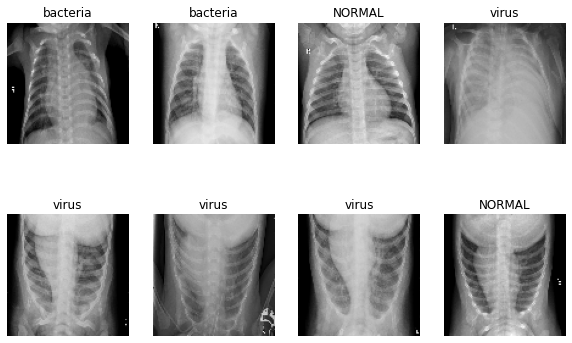

In [ ]:
#some data visualization for understanding
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(2):
  for i in range(8):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_name[labels_batch[i]])
    plt.axis("off")

In [ ]:
#data spliting fuction train = 70%, validation 20% and test =10%
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Importing the tensorflow.keras for model building
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
#Custom Model

conv_base = tf.keras.Sequential([
    layers.Conv2D(64, (3,3), strides=(2,2),padding='same',input_shape= (100,100,3),activation = 'relu'), 
    layers.MaxPool2D(2,2), 
    layers.Conv2D(128, (3,3), strides=(2,2),padding='same',activation = 'relu'),
    layers.MaxPool2D(2,2), 
    layers.Conv2D(256, (3,3), strides=(2,2),padding='same',activation = 'relu'), 
    layers.MaxPool2D(2,2),  
    layers.Flatten(), 
    layers.Dense(158, activation ='relu'), 
    layers.Dense(256, activation = 'relu'), 

])


x = conv_base.output
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, predictions)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
#Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20
)

Epoch 1/20
779/779 [==============================] - 137s 109ms/step - loss: 0.8798 - accuracy: 0.6660 - val_loss: 0.5007 - val_accuracy: 0.7967
Epoch 2/20
779/779 [==============================] - 34s 44ms/step - loss: 0.5564 - accuracy: 0.7802 - val_loss: 0.4545 - val_accuracy: 0.8164
Epoch 3/20
779/779 [==============================] - 34s 44ms/step - loss: 0.4985 - accuracy: 0.8015 - val_loss: 0.4150 - val_accuracy: 0.8215
Epoch 4/20
779/779 [==============================] - 34s 44ms/step - loss: 0.4805 - accuracy: 0.8060 - val_loss: 0.4080 - val_accuracy: 0.8423
Epoch 5/20
779/779 [==============================] - 34s 43ms/step - loss: 0.4341 - accuracy: 0.8243 - val_loss: 0.3616 - val_accuracy: 0.8508
Epoch 6/20
779/779 [==============================] - 34s 44ms/step - loss: 0.4084 - accuracy: 0.8370 - val_loss: 0.3827 - val_accuracy: 0.8373
Epoch 7/20
779/779 [==============================] - 34s 43ms/step - loss: 0.3916 - accuracy: 0.8444 - val_loss: 0.3827 - val_accurac

In [ ]:
scores = model.evaluate(test_ds)

113/113 [==============================] - 52s 11ms/step - loss: 0.2767 - accuracy: 0.9181


first image to predict
actual label: bacteria
predicted label: bacteria


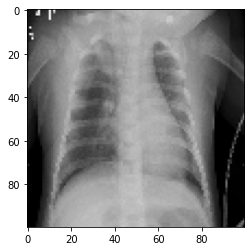

In [ ]:
#predicting a single image from test dataset
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[1].numpy().astype('uint8')
    first_label = labels_batch[1].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[1])])

In [ ]:
#function for prediction
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


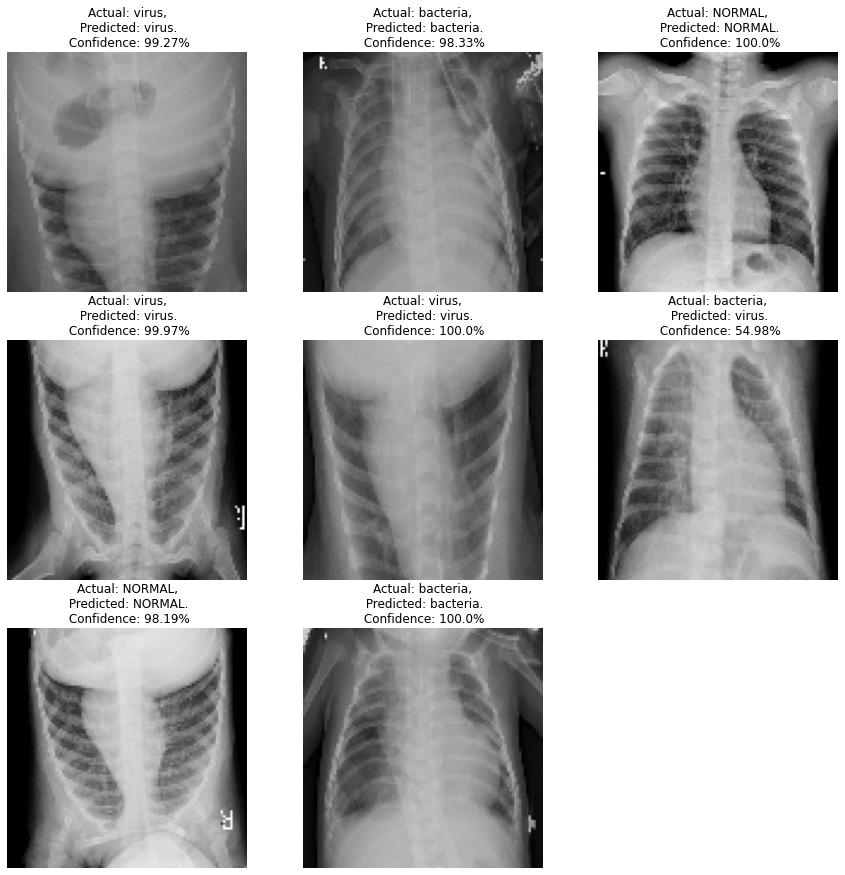

In [ ]:
#comparision of predction and actual class 
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(2):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence =predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

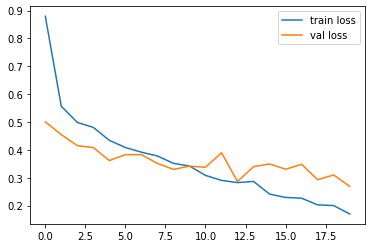

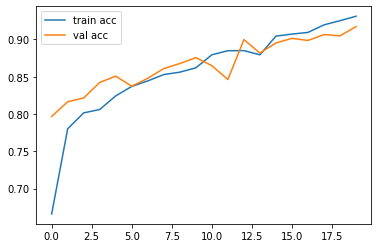

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
predicted = []
actual = []
for images, labels in test_ds:
  for i in range(8):
    predicted_class, confidence =predict(model, images[i].numpy())
    predicted.append(predicted_class)
    actual.append(class_name[labels[i]])
    # print(predicted_class,class_name[labels[i]])

In [ ]:
#calculating precision, recall and fscore
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(actual, predicted)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: [0.9847561  0.87128713 0.89010989]
recall: [0.94721408 0.93950178 0.86170213]
fscore: [0.96562033 0.90410959 0.87567568]


In [ ]:
#creating the confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

con_matrix = confusion_matrix(actual, predicted)
con_matrix

array([[323,   3,  15],
       [  2, 264,  15],
       [  3,  36, 243]])

In [ ]:
#ploting cf with better view 
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
  import matplotlib.pyplot as plt
  import numpy as np
  import itertools

  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
      cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
      tick_marks = np.arange(len(target_names))
      plt.xticks(tick_marks, target_names, rotation=45)
      plt.yticks(tick_marks, target_names)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="black" if cm[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="black" if cm[i, j] > thresh else "black")


  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

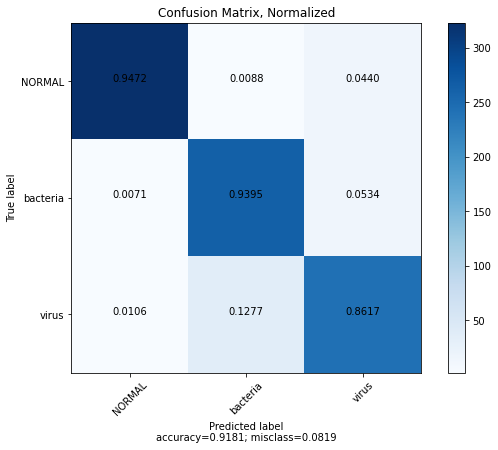

In [ ]:
plot_confusion_matrix(cm           = con_matrix, 
                      normalize    = True,
                      target_names = class_name,
                      title        = "Confusion Matrix, Normalized")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual, predicted, target_names=class_name))

              precision    recall  f1-score   support

      NORMAL       0.98      0.95      0.97       341
    bacteria       0.87      0.94      0.90       281
       virus       0.89      0.86      0.88       282

    accuracy                           0.92       904
   macro avg       0.92      0.92      0.92       904
weighted avg       0.92      0.92      0.92       904

